In [701]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from copy import deepcopy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import PIL
from PIL import Image
import skimage
from skimage import io
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score
import sys
import tensorflow as tf
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
from torchvision import models
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter


use_model = ''
this_file = ''

if use_model == '': use_model = 'a'
if this_file == '': this_file = 'a'


# data_path = "~/Datasets/iMet_Colelction_2019"
# load_path = "../input/"
load_path = "/home/sano/Datasets/iMet_Colelction_2019/input/"
# load_path = Path("~/Datasets/iMet_Colelction_2019/input")

log_dir = 'runs/' + this_file
weight_path = './model_weight/' + use_model + '/' + this_file


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)

print('log_dir = ', log_dir)
print('weight save path = ', weight_path)
# 複数GPU使用宣言
# if device == 'cuda:1':
#     net = torch.nn.DataParallel(net) # make parallel
#     cudnn.benchmark = True


torch.manual_seed(823)

device cuda
log_dir =  runs/a
weight save path =  ./model_weight/a/a


In [2]:
batch_size = 10
num_classes = 1103
epochs = 50
extract_attribute = 5 # 予測した上位何個を属性として出力するか

In [3]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [40]:
transform = transforms.Compose([
                            transforms.Resize((384,384)),
                            transforms.ToTensor(),
                            ])
a = Image.open(load_path + 'train/1000483014d91860.png')
b =  io.imread(load_path + 'train/1000483014d91860.png')
c = Image.fromarray(b)

In [9]:
class iMetsDataset(data.Dataset):
 
    def __init__(self, df, root_dir, transform=None, mode='train'):
        """
        Args:
            df (dataframe): ファイル名がindex、Nhot_LabelsカラムにNhot化したラベルを格納したDataframe
            root_dir (string): 対象の画像ファイルが入っているフォルダ
            transform (callable, optional): 施す変換
        """
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        print('a')
    def __len__(self):
        return len(self.df)
 
    def __getitem__(self, idx):
#         if type(idx) == torch.Tensor:
#             idx = idx.item()
        s = time.time()
        img_name = os.path.join(self.root_dir, self.df.index[idx])
        image = Image.fromarray(io.imread(img_name))
        global s1,s2
        s1 += time.time()-s
        s = time.time()
        if self.transform:
            image = self.transform(image)
        s2 += time.time()-s
        if self.mode == 'train':
            label = self.df.iloc[idx].Nhot_Labels.astype('float32')
            return image, label
        else:
            return image

In [50]:
%%time
for i,e in enumerate(submit_df.index[:1000]):
    a = Image.open(load_path + 'test/' + e)
    aa = transform(a)

CPU times: user 3min 19s, sys: 288 ms, total: 3min 19s
Wall time: 8.86 s


In [672]:
%%time

s1 = 0
s2 = 0
for i,e in enumerate(submit_df.index[:100]):
    s = time.time()
    a = Image.open(load_path + 'test/' + e)
    s1 += time.time()-s 
    s = time.time()
    bb = transform(b)
    s2 += time.time()-s
print(s1)
print(s2)
print(s1+s2)

0.06934142112731934
0.3165147304534912
0.38585615158081055
CPU times: user 9.04 s, sys: 12 ms, total: 9.05 s
Wall time: 387 ms


In [678]:
'/home/sano/Datasets/iMet_Colelction_2019/input/test/' + e

'/home/sano/Datasets/iMet_Colelction_2019/input/test/10023b2cc4ed5f68.png'

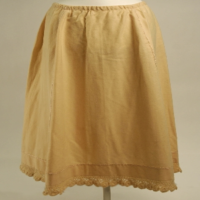

In [740]:
transforms.Resize((200,200))(a)

In [735]:
transforms.ToTensor()(a)

tensor([[[0.6471, 0.6510, 0.6549,  ..., 0.7216, 0.7176, 0.7137],
         [0.6471, 0.6510, 0.6549,  ..., 0.7216, 0.7059, 0.7137],
         [0.6471, 0.6471, 0.6549,  ..., 0.7176, 0.7176, 0.7176],
         ...,
         [0.6667, 0.6745, 0.6667,  ..., 0.7490, 0.7412, 0.7412],
         [0.6667, 0.6745, 0.6667,  ..., 0.7490, 0.7529, 0.7529],
         [0.6706, 0.6667, 0.6706,  ..., 0.7490, 0.7412, 0.7373]],

        [[0.6078, 0.6118, 0.6157,  ..., 0.6784, 0.6784, 0.6745],
         [0.6078, 0.6118, 0.6157,  ..., 0.6784, 0.6627, 0.6745],
         [0.6196, 0.6196, 0.6157,  ..., 0.6745, 0.6745, 0.6745],
         ...,
         [0.6314, 0.6392, 0.6314,  ..., 0.7098, 0.7020, 0.7020],
         [0.6275, 0.6392, 0.6314,  ..., 0.7098, 0.7137, 0.7137],
         [0.6314, 0.6314, 0.6353,  ..., 0.7098, 0.7020, 0.6980]],

        [[0.5098, 0.5137, 0.5176,  ..., 0.5922, 0.5804, 0.5765],
         [0.5098, 0.5137, 0.5176,  ..., 0.5922, 0.5765, 0.5765],
         [0.5176, 0.5176, 0.5176,  ..., 0.5882, 0.5882, 0.

In [727]:
%%time

transform = transforms.Compose([
                            transforms.Resize((384,384)),
#                             transforms.ToTensor(),
                            ])
pil_open = 0
pil_trans = 0
io_open = 0
io_trans = 0
for i,file_name in enumerate(submit_df.index[:20]):
    s = time.time()
    a = PIL.Image.open('/home/sano/Datasets/iMet_Colelction_2019/input/test/' + file_name)
#     a = a.convert('RGB')
    pil_open += time.time()-s 
    
    s = time.time()
    aa = transform(a)
    pil_trans += time.time()-s
    
    s = time.time()
    b = PIL.Image.fromarray(skimage.io.imread('/home/sano/Datasets/iMet_Colelction_2019/input/test/' + file_name))
    io_open += time.time()-s 

    s = time.time()
    bb = transform(b)
    io_trans += time.time()-s
    
print('pil_open  =', pil_open)
print('pil_trans =', pil_trans)
print('pil_total =', pil_open + pil_trans)
print()
print('io_open   =', io_open)
print('io_trans  =', io_trans)
print('io_total  =', io_open + io_trans)

pil_open  = 0.02021956443786621
pil_trans = 0.13776206970214844
pil_total = 0.15798163414001465

io_open   = 0.11576581001281738
io_trans  = 0.046131134033203125
io_total  = 0.1618969440460205
CPU times: user 284 ms, sys: 16 ms, total: 300 ms
Wall time: 321 ms


In [664]:
%%time
s1 = 0
s2 = 0
for i,e in enumerate(submit_df.index[:100]):
    s = time.time()
    b = Image.fromarray(io.imread(load_path + 'test/' + e))
    s1 += time.time()-s 
    s = time.time()
    bb = transform(b)
    s2 += time.time()-s
print(s1)
print(s2)
print(s1+s2)

0.6230878829956055
0.2756497859954834
0.8987376689910889
CPU times: user 20.1 s, sys: 12 ms, total: 20.1 s
Wall time: 900 ms


In [608]:
s = time.time()
bb = transform(b)
time.time()-s


0.0035190582275390625

In [60]:
transform = transforms.Compose([
                            transforms.Resize((384,384)),
                            transforms.ToTensor(),
                            ])
a = Image.open(load_path + 'train/1000483014d91860.png')
b =  io.imread(load_path + 'train/1000483014d91860.png')
c = Image.fromarray(b)

In [82]:
%%time
for i in range(1000):
    transform(c)

CPU times: user 45 s, sys: 140 ms, total: 45.2 s
Wall time: 1.89 s


In [83]:
%%time
for i in range(1000):
    transform(a)

CPU times: user 43.7 s, sys: 4 ms, total: 43.7 s
Wall time: 1.82 s


In [12]:
%%time 
s1 = 0
s2 = 0
for i in range(1000):
    a = ds_test[i]

CPU times: user 2min 26s, sys: 264 ms, total: 2min 27s
Wall time: 6.44 s


In [13]:
print(s1)
print(s2)
print(s1+s2)

6.06267237663269
0.36781978607177734
6.430492162704468


In [35]:
%%time 
t1 = 0
t2 = 0
for i in range(1000):
    a = ds_test[i]

CPU times: user 3min 12s, sys: 244 ms, total: 3min 12s
Wall time: 8.74 s


In [36]:
print(t1)
print(t2)
print(t1+t2)

1.2661550045013428
7.4652934074401855
8.731448411941528


In [742]:
class iMetsDataset(data.Dataset):
 
    def __init__(self, df, root_dir, transform=None, mode='train'):
        """
        Args:
            df (dataframe): ファイル名がindex、Nhot_LabelsカラムにNhot化したラベルを格納したDataframe
            root_dir (string): 対象の画像ファイルが入っているフォルダ
            transform (callable, optional): 施す変換
        """
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
 
    def __len__(self):
        return len(self.df)
 
    def __getitem__(self, idx):
#         if type(idx) == torch.Tensor:
#             idx = idx.item()
        t = time.time()
        img_name = os.path.join(self.root_dir, self.df.index[idx])
        image = Image.open(img_name)
        global t1,t2
        t1 += time.time()-t
        t = time.time()
        if self.transform:
            image = self.transform(image)
        t2 += time.time()-t
        if self.mode == 'train':
            label = self.df.iloc[idx].Nhot_Labels.astype('float32')
            return image, label
        else:
            return image
    
def Nhot_encoding(arr, l):
    """
    Nhotエンコーディングを行う

    Parameters
    ----------
    arr : ndarray
        ラベル
    l : int
        総ラベル数
    """
    if arr.ndim == 1:
        ret = np.zeros(l,dtype='int')
        ret[arr] = 1
        return ret
    else:
        lst = list()
        for i,_ in enumerate(arr):
            lst.extend([i] * arr.shape[1])
            
        ret = np.zeros((arr.shape[0],l),dtype='int')
        ret[lst,arr.flatten()] = 1
        return ret

データ呼び出し

In [743]:
label_name = pd.read_csv(load_path + 'labels.csv')
label_name = label_name.set_index("attribute_id")
submit_df = pd.read_csv(load_path + 'sample_submission.csv')
submit_df["id"] = submit_df["id"].apply(lambda x: x + ".png")
submit_df = submit_df.set_index('id')
test_size = len(submit_df)

train_df = pd.read_csv(load_path + 'train.csv')
train_size = len(train_df)
train_df["attribute_ids"] = train_df["attribute_ids"].apply(lambda x: np.array([int(s) for s in x.split(" ")]))
train_df["Nhot_Labels"] = train_df["attribute_ids"].apply(lambda x: Nhot_encoding(x,1103))
train_df["id"] = train_df["id"].apply(lambda x: x + ".png")
train_df = train_df.set_index('id')

In [747]:
torch.manual_seed(823)
np.random.seed(823)

ds_allTrain = iMetsDataset(train_df,load_path+'train',
#                             transform = transforms.Compose([
#                             transforms.Resize((384,384)),
#                             transforms.ToTensor(),
#                             ]),
                        )

ds_train, ds_valid = data.random_split(ds_allTrain, [90000, 19237])

ds_test = iMetsDataset(submit_df,load_path+'test',
                            transform = transforms.Compose([
                            transforms.Resize((384,384)),
                            transforms.ToTensor(),
                            ]),
                           mode='test'
                        )

if type(ds_train.indices) == torch.Tensor:
    ds_train.indices = ds_train.indices.numpy()
    ds_valid.indices = ds_valid.indices.numpy()


dataloader_train = data.DataLoader(dataset=ds_train,batch_size=batch_size,shuffle=True)
dataloader_valid = data.DataLoader(dataset=ds_valid,batch_size=batch_size,shuffle=False)
dataloader_test = data.DataLoader(dataset=ds_test,batch_size=batch_size,shuffle=False)

モデルを定義

In [748]:

torch.manual_seed(823)
np.random.seed(823)


resnet152 = models.resnet152(pretrained=True)

# Newly created modules have require_grad=True by default
num_features = resnet152.fc.in_features
features = list(resnet152.fc.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, num_classes)]) # Add our layer
resnet152.fc = nn.Sequential(*features) # Replace the model classifier
# load weight
# resnet152.load_state_dict(torch.load('model_weight/resnet152/resnet152_FocalLoss_epoch7.pkl'))
model = resnet152.to(device)

In [749]:
# criterion = nn.BCELoss()
criterion = FocalLoss(gamma=4, logits=False)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train,eval,predictの定義

In [750]:
global_step = 0
def train(epoch, writer):
    start = time.time()
    model.train()
    steps = len(ds_train)//batch_size
    for step, (images, labels) in enumerate(dataloader_train, 1):
        global global_step
        global_step += 1
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = torch.sigmoid(model(images))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            elapsed_time = time.time() - start
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.10f, time: %d分%d秒' % (epoch, epochs, step, steps, loss.item(), elapsed_time//60, int(elapsed_time % 60)))
            writer.add_scalar('train/train_loss', loss.item() , global_step)

            
def eval(epoch, writer):
    start = time.time()
    model.eval()
    fbeta_lst = list()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader_valid):
            images, labels = images.to(device), labels.to(device)
            labels = labels.cpu().detach().numpy()
            outputs = torch.sigmoid(model(images))
            outputs = outputs.cpu().detach().numpy()
            outputs_topN = np.argsort(outputs, axis=1)[:,-extract_attribute:]
            outputs_topN_Nhots = Nhot_encoding(outputs_topN, num_classes)
            fbeta_lst.append(fbeta_score(labels,outputs_topN_Nhots, beta=2 ,average='samples'))
            
    elapsed_time = time.time() - start
    print("Val Acc : %.10f, time: %d分%d秒" % (sum(fbeta_lst)/len(fbeta_lst), elapsed_time//60, int(elapsed_time % 60)))
    writer.add_scalar('eval/val_acc', sum(fbeta_lst)*100/len(fbeta_lst), epoch)


def predict():
    pred_attr = list()
    model.eval()
    with torch.no_grad():
        for i, images in enumerate(dataloader_test,1):
            images = images.to(device)
            outputs = torch.sigmoid(model(images))
            outputs = outputs.cpu().detach().numpy()
            outputs_topN = np.argsort(outputs, axis=1)[:,-extract_attribute:]
            for attr in outputs_topN:
                pred_attr.append(attr)
            if i % 10 == 0:
                sys.stdout.write('\r[%d/%d]' % (min((i * batch_size),test_size), test_size))
                sys.stdout.flush()
    return pred_attr          

In [11]:
torch.manual_seed(1)
writer = SummaryWriter(log_dir)
 
for epoch in range(1, epochs+1):
    train(epoch, writer)
    eval(epoch, writer)
    torch.save(model.state_dict(), weight_path + '_epoch' + str(epoch)+'.pkl')


writer.close()

/home/sano/.pyenv/versions/anaconda3-5.3.1/envs/pytorch/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [1/50], Step [50/4500], Loss: 0.0014912694, time: 0分22秒


KeyboardInterrupt: 

In [ ]:
# pred = predict()
# pred_str = list()
# for lst in pred:
#     pred_str.append(" ".join(list(map(str, lst))))

# submit_df.index = submit_df.index.map(lambda x:x.rstrip(".png"))
# submit_df.attribute_ids = pred_str

# submit_df.to_csv("submission.csv", index=True)